# Speech Emotion Recognition

## I. Context

The aim of this notebook is to set up all speech emotion recognition preprocessing for the time distributed ConvNet. 

The data set used for training is the **RAVDESS** data set : https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391

The signal preprocessing include :
- Signal discretization
- Audio data augmentation
- Log-mel-spectrogram extraction
- Time distributed framing
- Build train and test data set

## II. General import

In [1]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

### Graph imports ###
import matplotlib.pyplot as plt
from PIL import Image

### Audio import ###
import librosa
import IPython
from IPython.display import Audio

## III. Set labels

In [2]:
# RAVDESS Database
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}

# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender_differentiation == True:
        if int(audio_file[18:-4])%2 == 0: # Female
            label = 'f_' + label
        if int(audio_file[18:-4])%2 == 1: # Male
            label = 'm_' + label
    return label

## IV. Import audio files

In [3]:
# Start feature extraction
print("Import Data: START")

# Audio file path and names
file_path = '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/Data'
file_names = os.listdir(file_path)

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad lenght (3.0 sec)
max_pad_len = 49100

# Compute spectogram for all audio file
for audio_index, audio_file in enumerate(file_names):
    
    if audio_file[6:-16] in list(label_dict_ravdess.keys()):
        
        # Read audio file
        y, sr = librosa.core.load(os.path.join(file_path, audio_file), sr=sample_rate, offset=0.5)
        
        # Z-normalization
        y = zscore(y)
        
        # Padding or truncated signal 
        if len(y) < max_pad_len:    
            y_padded = np.zeros(max_pad_len)
            y_padded[:len(y)] = y
            y = y_padded
        elif len(y) > max_pad_len:
            y = np.asarray(y[:max_pad_len])
        
        # Add to signal list
        signal.append(y)
        
        # Set label
        labels.append(set_label_ravdess(audio_file, False))

        # Print running...
        if (audio_index % 100 == 0):
            print("Import Data: RUNNING ... {} files".format(audio_index))
        
# Cast labels to array
labels = np.asarray(labels).ravel()

# Stop feature extraction
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))

Import Data: START
Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUNNING ... 1400 files
Import Data: RUNNING ... 1500 files
Import Data: RUNNING ... 1600 files
Import Data: RUNNING ... 1700 files
Import Data: RUNNING ... 1800 files
Import Data: RUNNING ... 1900 files
Import Data: RUNNING ... 2000 files
Import Data: RUNNING ... 2100 files
Import Data: RUNNING ... 2200 files
Import Data: RUNNING ... 2400 files
Import Data: END 

Number of audio files imported: 2263


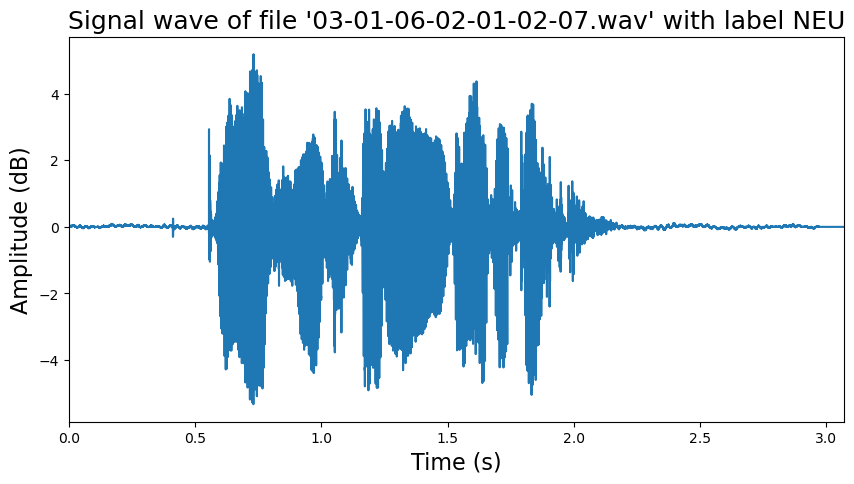

Audio file '03-01-06-02-01-02-07.wav':


In [5]:
# Select one random audio file
random_idx = np.random.randint(len(labels))
random_label = labels[random_idx]
random_signal = signal[random_idx]
random_filename = file_names[random_idx]

# Plot signal wave
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with label {}".format(random_filename, random_label), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
Audio(random_signal, rate=sample_rate)

## V. Audio data augmentation

In [20]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):
    
    # Signal length
    signal_len = len(signal)

    # Generate White noise
    noise = np.random.normal(size=(nb_augmented, signal_len))
    
    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
    # Random SNR: Uniform [15, 30]
    snr = np.random.randint(snr_low, snr_high)
    
    # Compute K coeff for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K
    
    # Generate noisy signal
    return signal + K.T * noise

In [21]:
# Generate noisy signals from signal list
print("Data Augmentation: START")
augmented_signal = list(map(noisy_signal, signal))
print("Data Augmentation: END!")

Data Augmentation: START
Data Augmentation: END!


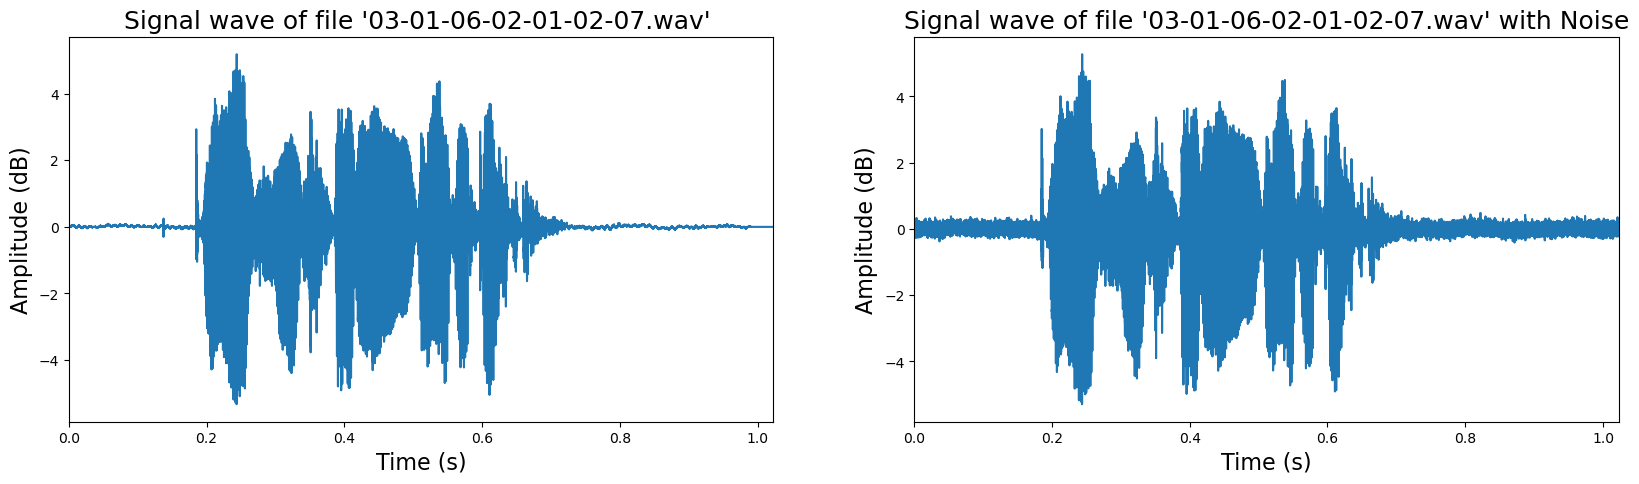

Audio file '03-01-06-02-01-02-07.wav':


Audio file '03-01-06-02-01-02-07.wav' with noise:


In [22]:
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' ".format(random_filename), fontsize=18)

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title("Signal wave of file '{}' with Noise".format(random_filename), fontsize=18)
plt.show()

# Play audio file
print("Audio file '{}':".format(random_filename))
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print("Audio file '{}' with noise:".format(random_filename))
IPython.display.display(Audio(augmented_signal[random_idx][0], rate=sample_rate))

## VI. Feature extraction

In [23]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [24]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
augmented_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i]))) for i in range(len(augmented_signal))]

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
Feature extraction: END!


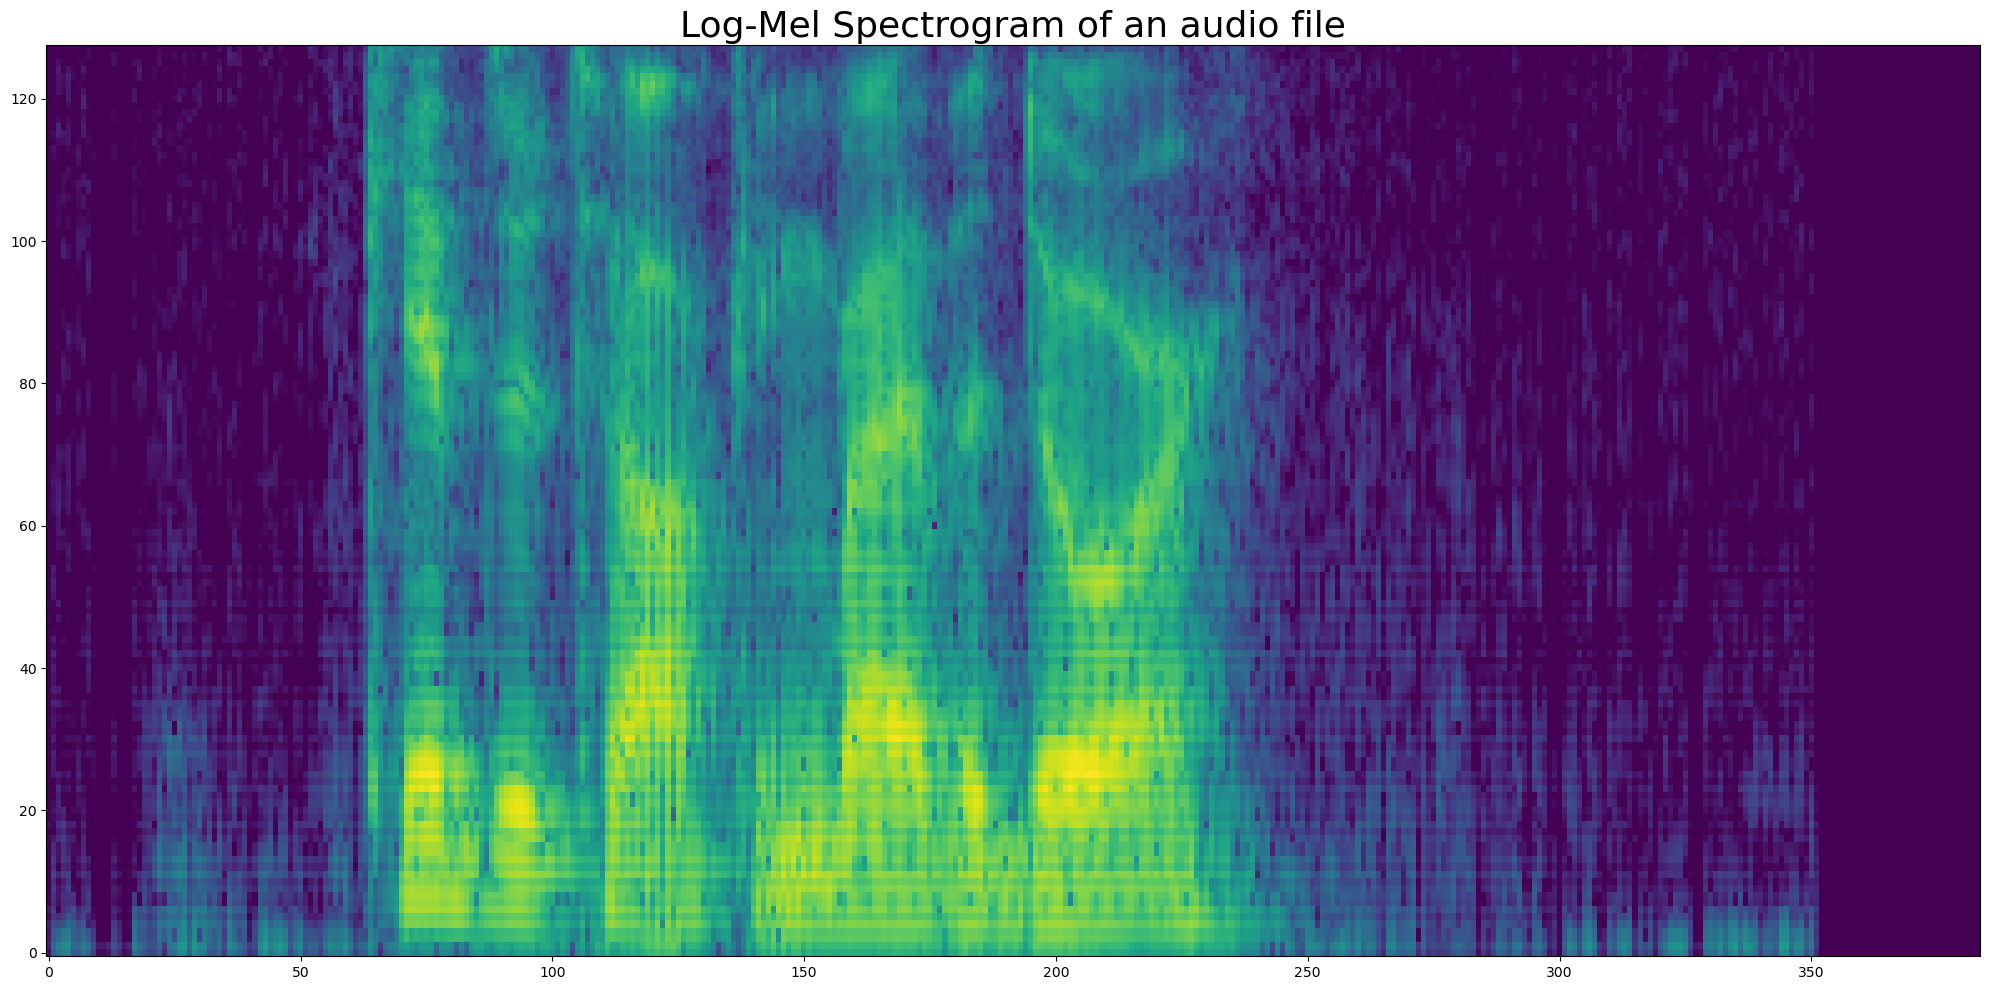

In [26]:
# Plot one random Spectogram 
plt.figure(figsize=(20, 10))
plt.imshow(mel_spect[np.random.randint(len(mel_spect))], origin='lower', aspect='auto', cmap='viridis')
plt.title('Log-Mel Spectrogram of an audio file', fontsize=26)
plt.tight_layout()
plt.show()

## VII. Train and test set

In [27]:
# Build Train and test dataset
MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))

# Concatenate original and augmented
X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
y_train = np.concatenate((label_train, aug_label_train))

# Build test set
X_test = MEL_SPECT_test
y_test = label_test

# Delete
del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, aug_label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
del mel_spect, augmented_mel_spect, labels

## VIII. Time distributed framing

In [29]:
# Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

# Frame for TimeDistributed model
X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)

In [33]:
X_train[0].shape    

(5, 128, 128)

## IX. Save as

In [34]:
# Save Train and test set
pickle.dump(X_train.astype(np.float16), open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][X_train].p', 'wb'))
pickle.dump(y_train, open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][X_test].p', 'wb'))
pickle.dump(y_test, open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][MEL_SPECT][y_test].p', 'wb'))